In [1]:
pip install pandas numpy scikit-learn nltk matplotlib seaborn wordcloud tensorflow


# Importing the dataset

In [2]:
import pandas as pd
df=pd.read_csv('tweets.csv',encoding='latin-1')
# Randomly sample 100,000 rows from the full dataset
df_small = df.sample(n=10000, random_state=42)
df_small.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
541200,0,2200003313,Tue Jun 16 18:18:13 PDT 2009,NO_QUERY,DEWGetMeTho77,@Nkluvr4eva My poor little dumpling In Holmde...
750,0,1467998601,Mon Apr 06 23:11:18 PDT 2009,NO_QUERY,Young_J,I'm off too bed. I gotta wake up hella early t...
766711,0,2300049112,Tue Jun 23 13:40:12 PDT 2009,NO_QUERY,dougnawoschik,I havent been able to listen to it yet My spe...
285055,0,1993474319,Mon Jun 01 10:26:09 PDT 2009,NO_QUERY,thireven,now remembers why solving a relatively big equ...
705995,0,2256551006,Sat Jun 20 12:56:51 PDT 2009,NO_QUERY,taracollins086,"Ate too much, feel sick"


In [3]:
print(df_small.shape)
print(df_small.columns)
df_small.columns = ['sentiment', 'id', 'date', 'query', 'user', 'tweet']


(10000, 6)
Index(['0', '1467810369', 'Mon Apr 06 22:19:45 PDT 2009', 'NO_QUERY',
       '_TheSpecialOne_',
       '@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D'],
      dtype='object')


In [4]:
df_small.head()
df_small['sentiment'] = df_small['sentiment'].replace(4, 1)
df_small.head()

,sentiment,id,date,query,user,tweet
541200,0,2200003313,Tue Jun 16 18:18:13 PDT 2009,NO_QUERY,DEWGetMeTho77,@Nkluvr4eva My poor little dumpling In Holmde...
750,0,1467998601,Mon Apr 06 23:11:18 PDT 2009,NO_QUERY,Young_J,I'm off too bed. I gotta wake up hella early t...
766711,0,2300049112,Tue Jun 23 13:40:12 PDT 2009,NO_QUERY,dougnawoschik,I havent been able to listen to it yet My spe...
285055,0,1993474319,Mon Jun 01 10:26:09 PDT 2009,NO_QUERY,thireven,now remembers why solving a relatively big equ...
705995,0,2256551006,Sat Jun 20 12:56:51 PDT 2009,NO_QUERY,taracollins086,"Ate too much, feel sick"


In [5]:
print(df_small.iloc[0,5])

@Nkluvr4eva My poor little dumpling  In Holmdel vids he was really trying...Hope he dont try to hard tonight xx


# Importing Libraries

In [6]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

# Cleaning the dataset

In [7]:
# Function to clean tweet text
def preprocess_tweet(tweet):
    tweet = re.sub(r'http\S+', '', tweet)  # Remove URLs
    tweet = re.sub(r'@\w+', '', tweet)  # Remove mentions
    tweet= re.sub(r'#\w+', '', tweet)  # Remove hashtags
    tweet = re.sub(r'\d+', '', tweet)  # Remove numbers
    tweet= tweet.lower()  # Convert to lowercase
    tweet = re.sub(r'[^\w\s]', '', tweet)  # Remove punctuation

    # Tokenization
    words = tweet.split()

    # Remove stopwords
    words = [word for word in words if word not in stopwords.words('english')]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    return ' '.join(words)

df_small['cleaned_tweet'] = df_small['tweet'].apply(preprocess_tweet)

# Splitting the dataset into train (80%) and test (20%)

In [8]:
from sklearn.model_selection import train_test_split #to split the data into training and testing

X_train, X_test, y_train, y_test = train_test_split(df_small['cleaned_tweet'], df_small['sentiment'], test_size=0.2, random_state=42)


# Tokenizatoin and Padding

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenization
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df_small['cleaned_tweet'])

# Convert text to sequences of integers
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure equal length
maxlen = 50  # You can adjust this depending on the average tweet length
X_train_padded = pad_sequences(X_train_seq, maxlen)
X_test_padded = pad_sequences(X_test_seq, maxlen)

# Building the RNN (LSTM) model

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout

# Model architecture
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=maxlen)) #as set by the num_words in tokenizer (most used 5000 words)
model.add(Bidirectional(LSTM(units=64, return_sequences=True))) #return_sequences=True: LSTM layer returns the full sequence of outputs for each input sequence, which is necessary because we have another LSTM layer following this one.
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(units=32)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# Training the model

In [11]:
# Training the model
history = model.fit(X_train_padded, y_train, epochs=5, batch_size=64, validation_data=(X_test_padded, y_test))


Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 39s 244ms/step - accuracy: 0.5413 - loss: 0.6811 - val_accuracy: 0.7180 - val_loss: 0.5530
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 38s 224ms/step - accuracy: 0.8014 - loss: 0.4591 - val_accuracy: 0.7210 - val_loss: 0.5534
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 43s 243ms/step - accuracy: 0.8472 - loss: 0.3683 - val_accuracy: 0.6940 - val_loss: 0.6049
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 26s 211ms/step - accuracy: 0.8856 - loss: 0.3071 - val_accuracy: 0.6815 - val_loss: 0.7379
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 46s 254ms/step - accuracy: 0.9001 - loss: 0.2621 - val_accuracy: 0.7035 - val_loss: 0.7450


# Evaluation of the model

In [12]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Evaluate the model
loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f'Test Accuracy: {accuracy:.4f}')

# Make predictions on the test set
y_pred = (model.predict(X_test_padded) > 0.5).astype("int32")

# Print accuracy
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

# Print confusion matrix
print(confusion_matrix(y_test, y_pred))

# Print classification report
print(classification_report(y_test, y_pred))


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.7246 - loss: 0.7053
Test Accuracy: 0.7035
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step
Accuracy: 0.7035
[[707 273]
 [320 700]]
              precision    recall  f1-score   support

           0       0.69      0.72      0.70       980
           1       0.72      0.69      0.70      1020

    accuracy                           0.70      2000
   macro avg       0.70      0.70      0.70      2000
weighted avg       0.70      0.70      0.70      2000



# Visualizaiton of the model

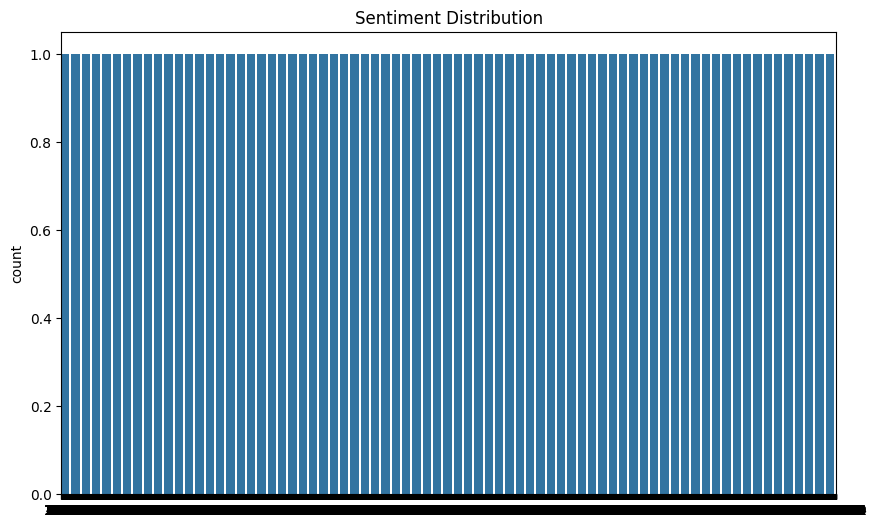

In [20]:
plt.figure(figsize=(10, 6))
sns.countplot(df_small['sentiment'])
plt.title('Sentiment Distribution')
plt.show()


# Accuracy and loss

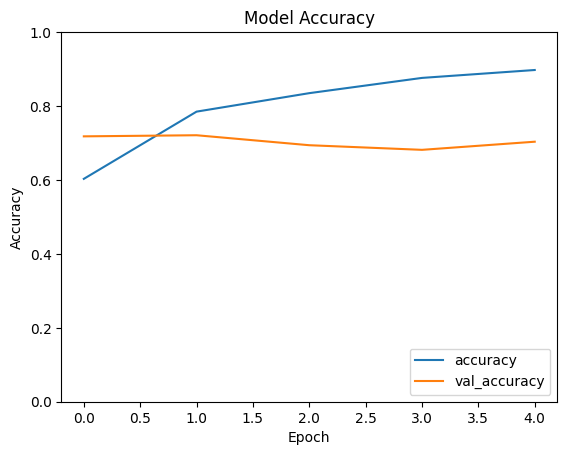

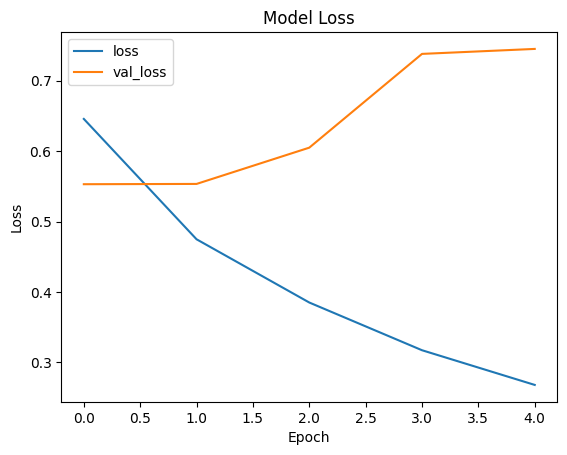

In [21]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Model Accuracy')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.title('Model Loss')
plt.show()


# Wordcloud Illustration

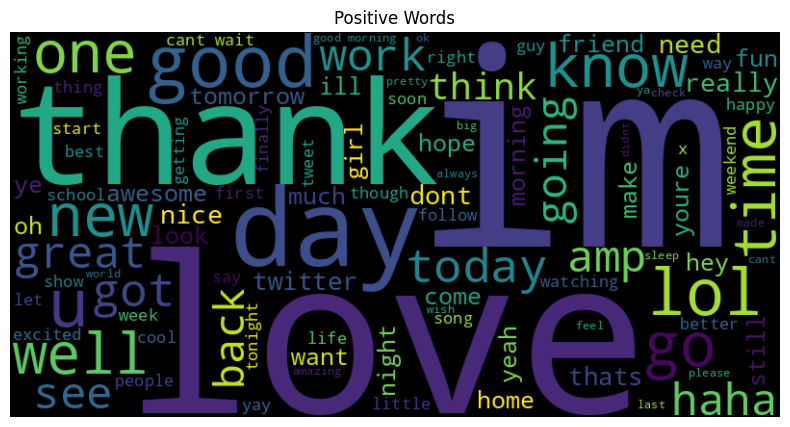

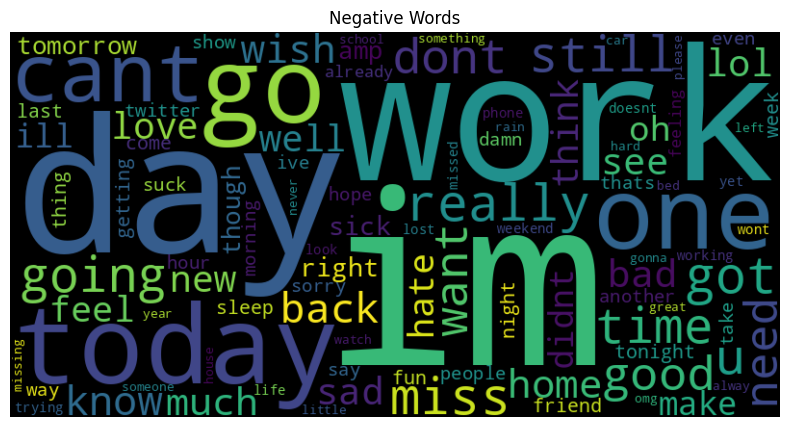

In [17]:
from wordcloud import WordCloud

# Word cloud for positive sentiment
positive_text = ' '.join(df_small[df_small['sentiment'] == 1]['cleaned_tweet'])
wordcloud = WordCloud(width=800, height=400, max_words=100).generate(positive_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Words')
plt.show()

# Word cloud for negative sentiment
negative_text = ' '.join(df_small[df_small['sentiment'] == 0]['cleaned_tweet'])
wordcloud = WordCloud(width=800, height=400, max_words=100).generate(negative_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Words')
plt.show()
